In [337]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles, make_classification, make_moons

# Метод главных компонент для синтетики

In [215]:
class PCA:
    """Principal component transformer/analyzer"""
    
    def __init__(self, n_components: int):
        self.n_components = n_components
        self._eigenvalues = None
        self._all_eigenvalues = None
        self._eigenvectors = None
        
    def describe_values(self):
        print('eigenvectors: ', self._eigenvectors)
        print('eigenvalues: ', self._eigenvalues)
    
    def fit(self, X):
        """Reduces dataset to defined number of principal components

        Args:
            X (_ArrayLike): Standardazed data set
        """
        
        cov_matrix = np.cov(X, rowvar=False)
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        
        self._all_eigenvalues = eigenvalues
        eigenvalues_indices = eigenvalues.argsort()[::-1]
        eigenvalues_indices = eigenvalues_indices[:self.n_components]
        
        self._eigenvectors = eigenvectors[:,eigenvalues_indices]
        self._eigenvalues = eigenvalues[eigenvalues_indices]
        
        return self
        
    def transform(self, X):
        """Transform passed data to defined number of features

        Args:
            X (_ArrayLike): Standardazed data set
        """
        return np.dot(X, self._eigenvectors)
    
    def fit_transform(self, X):
        return self.fit(X).transform(X)
    
    def inverse_transform(self, X):
        return np.dot(X, self._eigenvectors.T)
    
    def score(self, X):
        SStot = np.sum(np.square(X - np.mean(X)))
        SSres = np.sum(np.square(X - self.inverse_transform(self.fit_transform(X))))
        return 1 - SSres/SStot
    
    def compression_ratio(self, X):
        return (self.n_components * (X.shape[0] + X.shape[1])) / X.size 
    
    def plot_eigvalues(self, figsize=(15,7)):
        plt.figure(figsize=figsize)
        plt.plot(np.sort(self._all_eigenvalues)[::-1],'.',
                 label='Все собственные значения',
                 linewidth = 3)
        plt.plot(self._eigenvalues,'r-o',
                 label='Собственное Пространство',
                 markersize = 10, mfc='none',
                 linewidth = 2, alpha = 0.8)
        plt.ylabel('собственные\n значения', fontsize=25)
        plt.grid();
        plt.legend();
        plt.tight_layout();   

In [216]:
# ones (2, N)
# centers (2,2)
# ones x centers (2, N)
# noise (2, N)
# noise + (ones x centers)  (2, N)
# radius (2, 2) 
# radius x (noise + (ones x centers)) (2, N)
# rotation (2, 2)
# rotation x (radius x (noise + (ones x centers))) (2, N)

def synthesize_dataset(angle: int,
                       r1=20,
                       r2=5,
                       center=(0, 0),
                       n=100,
                       random=42):
    """Creates ellipsis like data shape, with normally distributed noise

    Returns:
        _ArrayLike: ellipsis like data shape
    """
    radian = np.pi / 180 * angle
    
    np.random.seed(random)
    ones = np.ones((2, n))
    centers = np.dot(np.diag([center[0], center[1]]), ones)
    noise = np.random.randn(2, n)
    centers_with_noise = centers + noise
    ellipsis = np.dot(np.diag([r1, r2]), centers_with_noise)
    
    rotation_matrix = np.array([
        [np.cos(radian), -np.sin(radian)],
        [np.sin(radian), np.cos(radian)]
    ])
    
    return np.dot(rotation_matrix, ellipsis).T
    
def scatter_dataset(X, Y, ax, title=None, axis_limit=40):
    ax.scatter(X, 
               Y,
               alpha=0.5,
               c='orange', 
               edgecolor='r')
    ax.grid();
    ax.set_title(title)
    plt.xlim((-axis_limit,axis_limit))
    plt.ylim((-axis_limit,axis_limit));

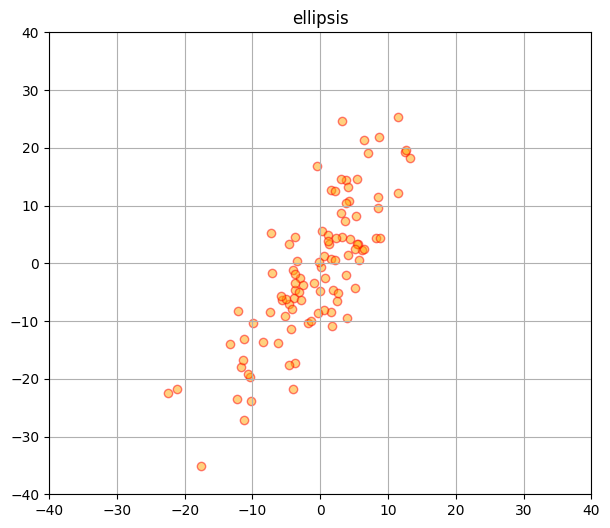

In [217]:
dataset = synthesize_dataset(angle=65, r1=15, r2=4)
_, ax = plt.subplots(figsize=(7,6))
scatter_dataset(dataset[:,0], dataset[:,1], ax, title='ellipsis')

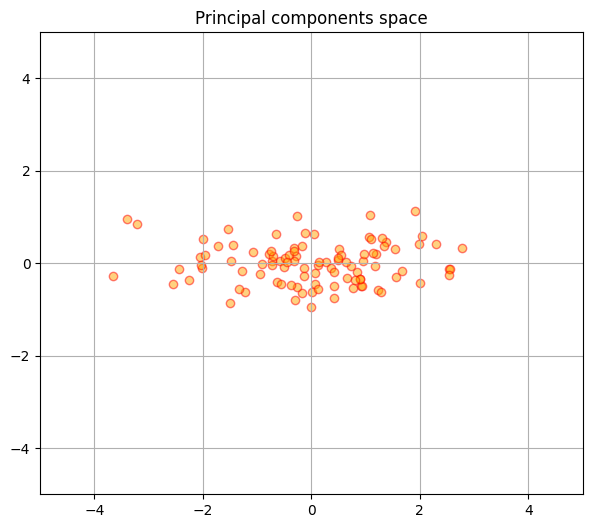

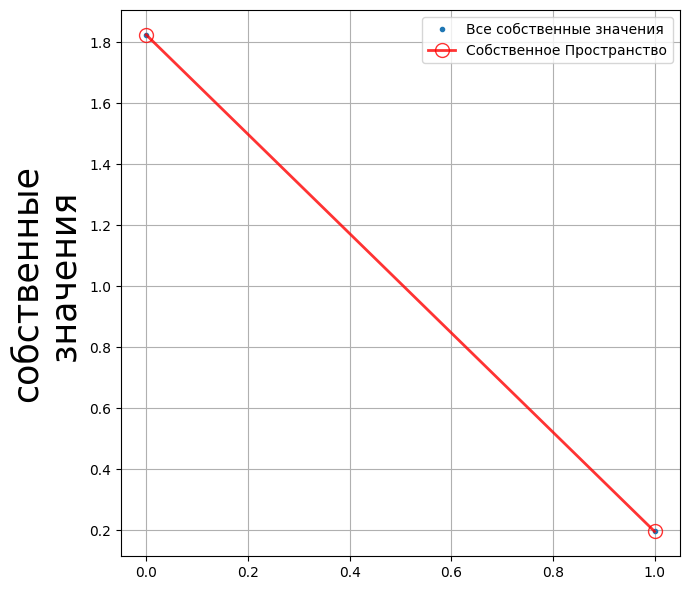

In [218]:
std_scaler = StandardScaler()
std_dataset = std_scaler.fit_transform(dataset)
pca = PCA(n_components=2)
pc_dataset = pca.fit_transform(std_dataset)

_, ax = plt.subplots(figsize=(7,6))
scatter_dataset(X=pc_dataset[:, 0], Y=pc_dataset[:, 1], ax=ax, title='Principal components space', axis_limit=5)
pca.plot_eigvalues(figsize=(7,6))

# Линейная комбинация собственных векторов с изначальными данными растянула по наиболее дисперсионной оси X 

In [219]:
# Оценка значений
print('pca min x: ', pc_dataset[:, 0].min(), 'pca min y: ', pc_dataset[:, 1].min())
print('pca max x:', pc_dataset[:, 0].max(), 'pca max y:', pc_dataset[:, 1].max())

# Сжали оси их распределение нормальное со средним в нуле и дисперсией = 1.

pca.describe_values()
pca._eigenvectors[:, 0]
# Хоть и есть сильная корреляция, видимо из-за шума коэффициент ковариации равен 0.7
# Первый и второй вектор подобраны так, что растяжение по оси X остается, а по оси Y сужается
# Можно рассмотреть это на примере
# Собственные значения говорят, что один из признаков наиболее важен - X

pca min x:  -3.649061006858678 pca min y:  -0.9503195774569516
pca max x: 2.7726835389748277 pca max y: 1.1213784962314113
eigenvectors:  [[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]
eigenvalues:  [1.82409183 0.19611019]


array([0.70710678, 0.70710678])

In [220]:
print('Пример преобразования вектора (5,10) методом главных компонент ->', np.dot([5, 10], pca._eigenvectors))
# Признак по оси икс получил больший коэффициент что и подразумевается

Пример преобразования вектора (5,10) методом главных компонент -> [10.60660172  3.53553391]


# Mnist data set

In [221]:
MNIST_ds = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame = True)
X, y  = MNIST_ds
X = X / 255.
X_ = X.values

In [222]:
# Utilities
def draw_digits(X, y, rnd=42):
    np.random.seed(rnd)
    fig = plt.figure(figsize=(12, 8))
    n=4
    
    indices = np.random.randint(0, X.shape[0], size=(n,))
    X = X[indices]
    y = y[indices]
    
    for idx in range(n):
        ax = fig.add_subplot(1, 4, idx+1)
        ax.set_title(f'Число: {y[idx]}', size=14, loc = "left")
        ax.imshow(X[idx].reshape(28, 28))
        
def validate_pca(n_components, X):
    pca = PCA(n_components)
    print('Compress ratio for n = 50: ', pca.compression_ratio(X))
    print('Coefficient of determination: ', pca.score(X))
    
    X_pca = pca.fit_transform(X)
    
    draw_digits(pca.inverse_transform(X_pca), y.values)
    plt.title('Recovered', loc = "right")
    draw_digits(X, y.values)
    plt.title('Original', loc = "right")

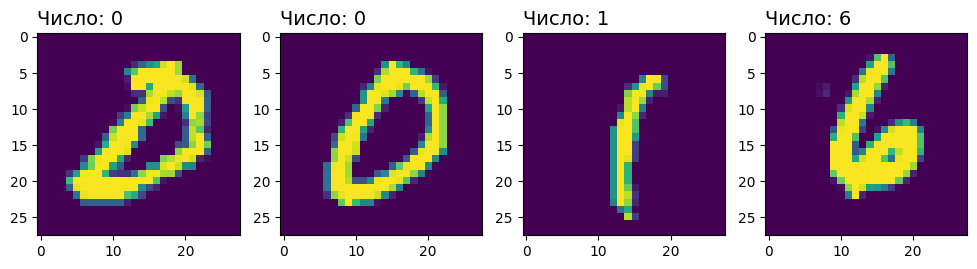

In [223]:
draw_digits(X_, y.values)

Compress ratio for n = 50:  0.06448979591836734
Coefficient of determination:  0.8742915174038527


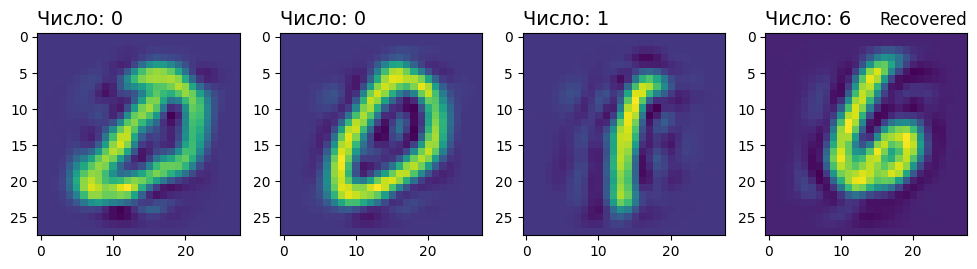

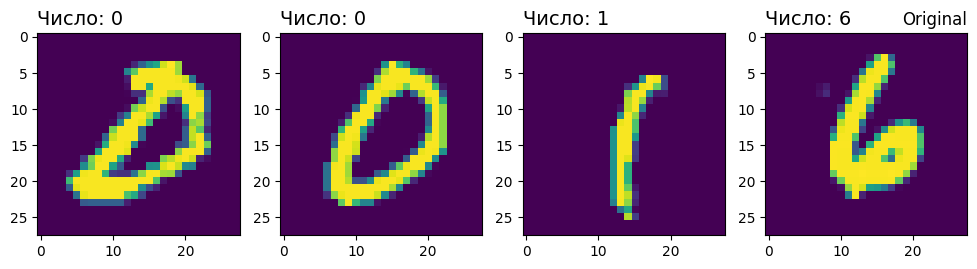

In [224]:
validate_pca(n_components=50, X=X_) # В целом плоховато, наверно надо побольше

Compress ratio for n = 50:  0.02579591836734694
Coefficient of determination:  0.7441652182416786


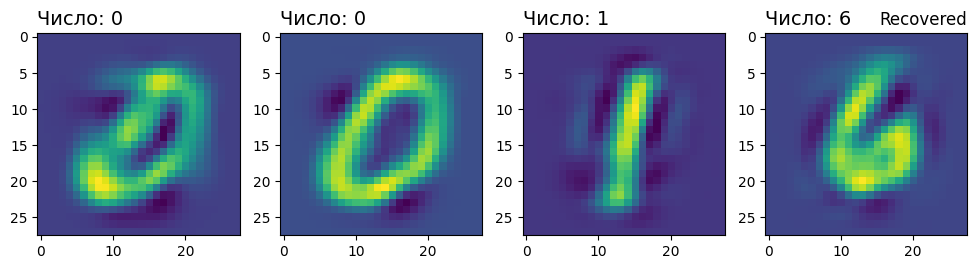

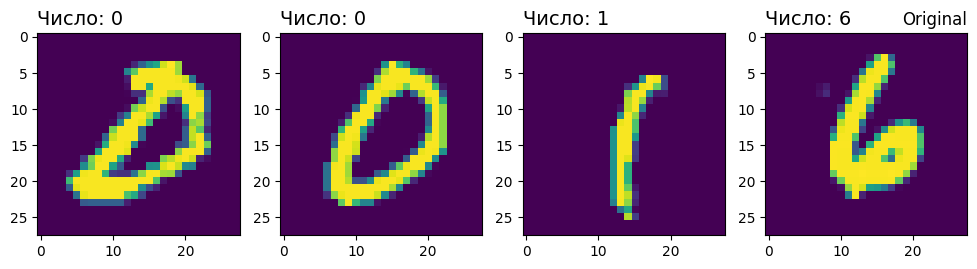

In [225]:
validate_pca(n_components=20, X=X_) # Но сначало посмотрим как выглядит 20

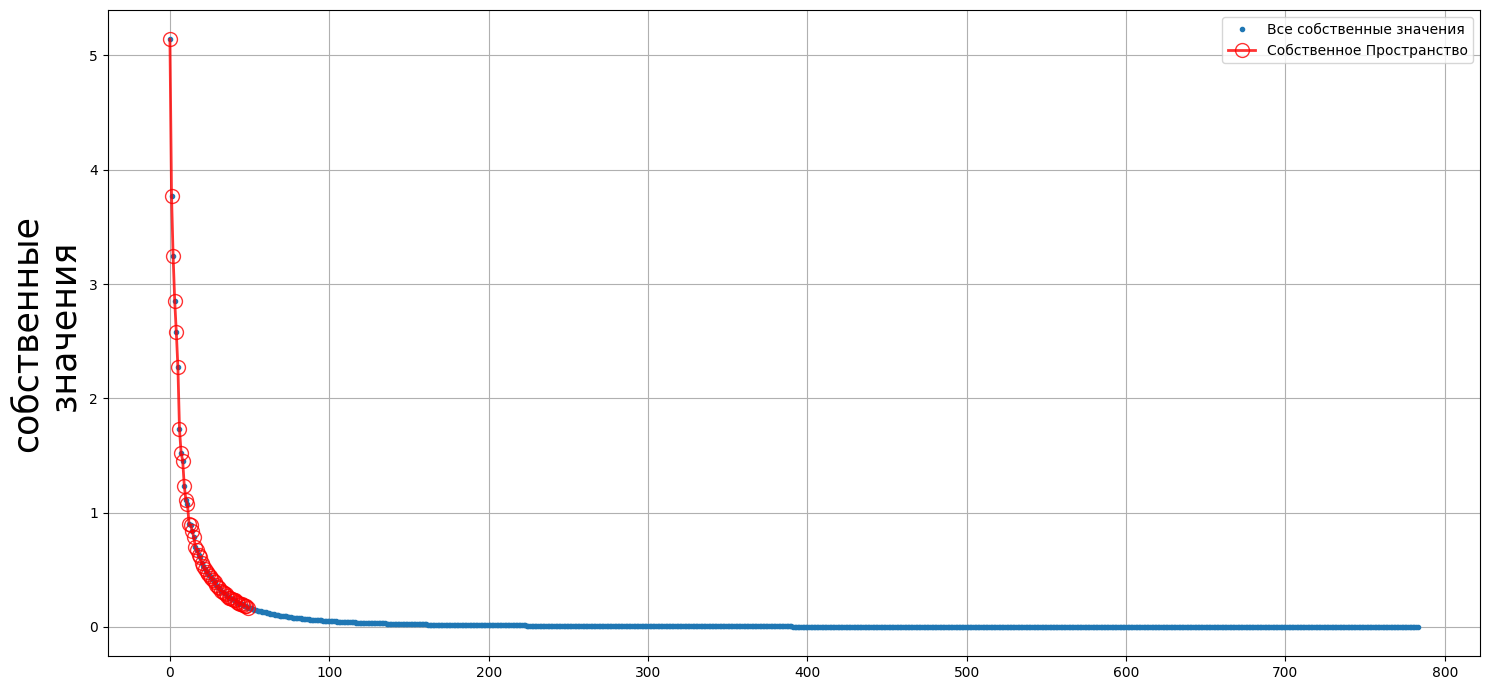

In [226]:
mnist_pca = PCA(n_components=50)
mnist_pca.fit(X_)
mnist_pca.plot_eigvalues() # В целом можно остановиться где-то на 75

# Собственные 

In [227]:
# TODO: last task

# Набор данных Cars Moldova

In [328]:
cars_df = pd.read_csv('datasets/enriched_df.csv', sep=',')
num_cols = cars_df.select_dtypes(include=np.number).columns
cars_df.head(5)
cars_df = cars_df.dropna(axis=0) # Удаляем пустые значения

In [229]:
std_transformer = StandardScaler()
X = std_scaler.fit_transform(cars_df[num_cols].values)

pca = PCA(n_components=4)
X_pca = pca.fit_transform(X)

pca.describe_values()

print([f'{feature} - {value}' for value, feature in zip(pca._all_eigenvalues, num_cols)])
# Год не особо значемый признак, а вот возраст наоборот, 
# пробег тоже достаточно дисперсионный, 
# дистанция почему-то не особо дисперсионна
# Выглядит так что дискретные значения получили большое собственное значение
# А многозначные неприрывные значения получили небольшое собственное значение

eigenvectors:  [[-0.51008943  0.05560591  0.17854037 -0.31076843]
 [ 0.27082466  0.68994549 -0.12455666  0.20795061]
 [-0.04242774  0.04493276 -0.84985882 -0.32009704]
 [-0.4224373  -0.07486497 -0.43127836  0.20034842]
 [ 0.51008943 -0.05560591 -0.17854037  0.31076843]
 [-0.26780923  0.71007718  0.09498592 -0.02639055]
 [-0.39280579 -0.07718723 -0.05872769  0.78759409]]
eigenvalues:  [3.35789941 1.35688647 1.22138028 0.67453276]
['Year - -4.587317274912755e-16', 'Distance - 0.1523789211031711', 'Engine_capacity(cm3) - 0.23716557797849888', 'Price(euro) - 0.674532755999289', 'Age - 1.2213802820011848', 'km_year - 1.3568864682068018', 'mean_price_deviation - 3.357899413704689']


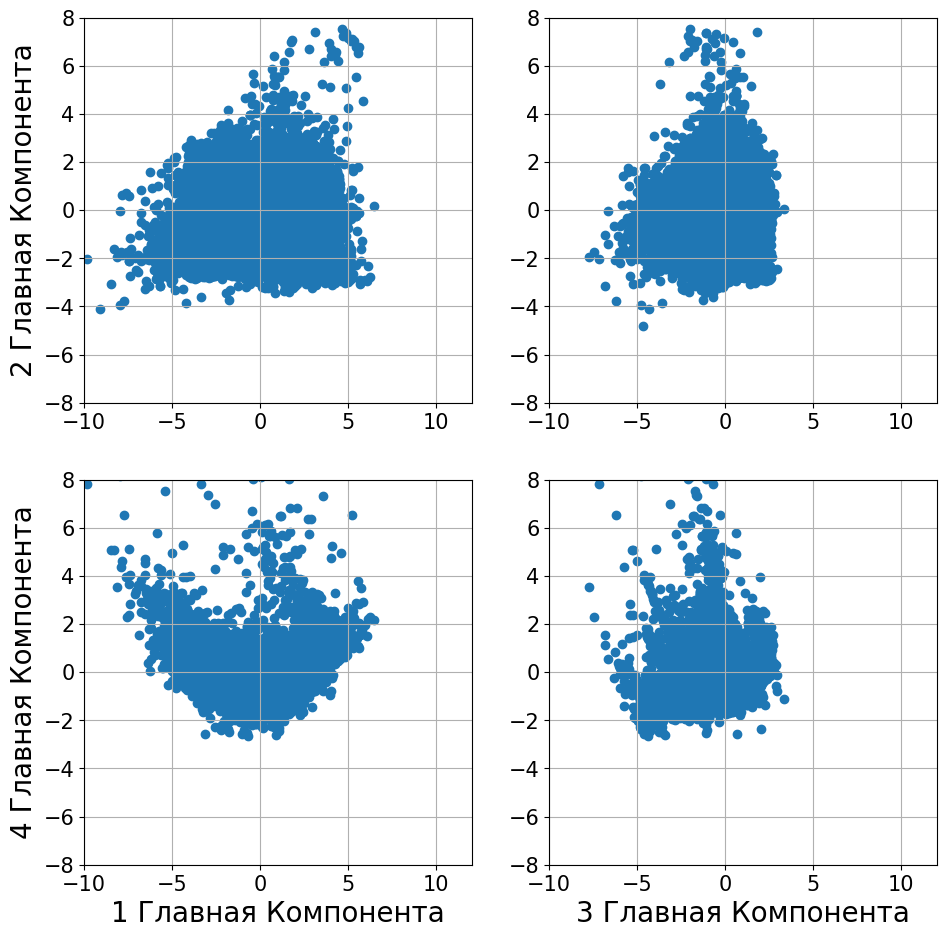

In [230]:
def plot_multi(data, names):
    axis = [[0,1],
            [2,1],
            [0,3],
            [2,3],]
    fig, sub = plt.subplots(2, 2, figsize = (11,11))
    
    labels = [['',names[1]],
            ['',''],
            [names[0],names[3]],
            [names[2],'']]

    for n, (axi, label, ax) in enumerate(zip(axis, labels, sub.flatten())):
        ax.set_ylabel(label[1], fontsize = 20)
        ax.set_xlabel(label[0], fontsize = 20)
        scatter = ax.scatter(data[:,axi[0]],data[:,axi[1]]);
        ax.tick_params(axis='x', labelsize= 15)
        ax.tick_params(axis='y', labelsize= 15)     
        ax.grid()
        ax.set_xlim([-10,12])
        ax.set_ylim([-8,8])
        
plot_multi(X_pca, [str(x+1)+' Главная Компонента' for x in range(4)])
# Не понял как это читать

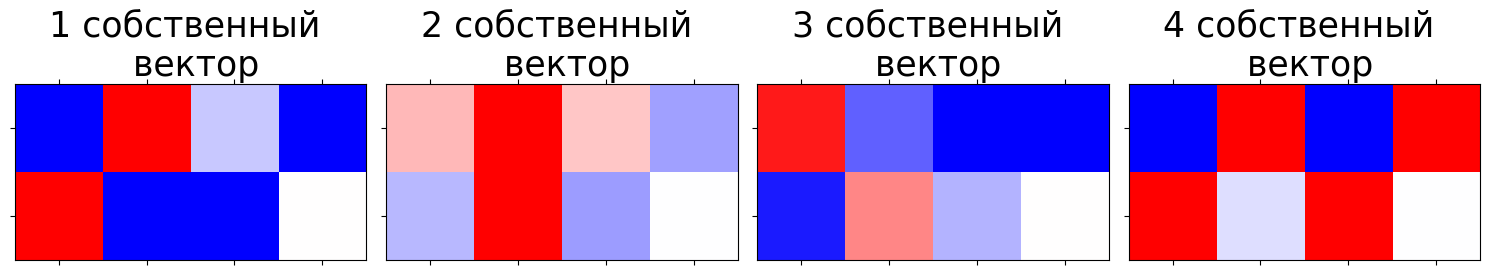

In [231]:
W_pca = np.column_stack((pca._eigenvectors.T, np.zeros((pca._eigenvectors.T.shape[0], 1))))

fig=plt.figure(figsize=(15,5))
for i in range(0,4):
  ax = fig.add_subplot(1,4,i+1,title=str(i+1) )
  ax.set_title("{} собственный \n вектор".format(str(i+1)), size=25)
  ax.matshow(W_pca[i].reshape((2,4)).astype(float), cmap = 'bwr', vmin=-0.20,vmax = 0.20)
  plt.setp(ax.get_xticklabels(), visible=False)
  plt.setp(ax.get_yticklabels(), visible=False)
plt.tight_layout();

# Тоже нет понимания как это интерпретировать =(

In [232]:
# Utilities
def sigmoid(z):
        return 1 / (1 + np.e ** (-z))

def sigmoid_derivation(z):
    return sigmoid(z) - sigmoid(z) ** 2

def convert_to_polynom(X, degree: int = 2):
    """Raises every given features up to specified degrees, starting from second degree"""
    
    X = np.atleast_2d(X)
    out = X.copy()
    for degree in range(2, degree + 1):
        out = np.column_stack((out, X ** degree))
    
    return out

# Создаим класс для регрессии

class LogisticRegression():
    """Logistic regression classifier"""
    
    def __init__(self, 
                 weights=None,
                 learning_rate=0.25, 
                 l1_penalty=0.0,
                 l2_penalty=0.0,
                 threshold=0.5,
                 batch_size=1000, 
                 n_batches=None,
                 random_state=42):
        
        self.weights = weights
        self.learning_rate = learning_rate
        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty
        self.threshold = threshold
        self.batch_size = batch_size
        self.n_batches = n_batches
        self.random_state = random_state
        
    def _init_weights(self, n_features: int, rnd=42) -> np.array:
        """Init inital random weights"""
        
        np.random.seed(rnd)
        weights = np.random.randn(n_features)
        self.weights = np.atleast_2d(weights).T
        
        return self.weights

    def _sigmoid(self, z):
        """Plain sigmoid"""
        
        return 1 / (1 + np.e ** (-z))

    def _sigmoid_derivation(self, z):
        """Derivative of sigmoid function"""
        
        return self.sigmoid(z) - self.sigmoid(z) ** 2
    
    def loss(self, X, y_true):
        """Cross entropy loss function"""
        
        pass
    
    def loss_gradient(self, X, y_hat, y) -> np.array:
        """Gradient of loss function"""
        loss = 2 * np.dot(X.T, (y_hat - y)) / y.size
        
        return loss
    
    def _update_weights(self, delta):
        """Updates weights including regulization"""
        
        l2_ = self.l2_penalty * np.sum(self.weights[1:])
        l1_ = np.sign(self.weights) * self.l1_penalty
        delta = delta + l1_ + l2_
        self.weights -= self.learning_rate * delta
    
    def predict(self, X) -> int:
        """Predict dataset classification probability"""
        
        X = np.atleast_2d(np.array(X))
        
        # Probably it should it be places somewhere else
        if X.shape[0] != self.weights.size:
            X = self._add_bias_to_x(X)
            assert X.shape[1] == self.weights.size
        
        arg = self.linear_combination(X, self.weights)
        return sigmoid(arg)
    
    def linear_combination(self, X, weights):
        return np.dot(X, weights)
    
    def _add_bias_to_x(self, X):
        """Adds bias to features instance"""
        X = np.atleast_2d(X)
        return np.column_stack((
            np.ones((X.shape[0], 1)),
            X
        ))
    
    def predict_class(self, x) -> int:
        """Predicts class of instance"""
        
        return int(self.predict(x) >= self.threshold)
        
    def fit(self, X, y_true, epsilon=1e-2, epochs=None):
        """Model fitting algorithm"""
        
        y_true = np.atleast_2d(y_true).T
        epochs = epochs or 0
        if self.weights is None:
            self._init_weights(X.shape[1] + 1) # + 1 adds bias
        
        while True:
            epochs -= 1
            
            y_hat = self.predict(X)
            loss_gradient = self.loss_gradient(self._add_bias_to_x(X), y_hat=y_hat, y=y_true)
            self._update_weights(loss_gradient)
            
            if loss_gradient.sum() <= epsilon:
                break
            if epochs == 0:
                break
    
    def _metrics_data(self, y_hat, y):        
        tp = np.where((y_hat == 1) & (y == 1))
        fn = np.where((y_hat == 0) & (y == 1))
        fp = np.where((y_hat == 1) & (y == 0))
        tn = np.where((y_hat == 0) & (y == 0))
        
        return tp, fn, fp, tn
            
    def prediction_report(self, X, y):
        """Metrics report"""
        y_hat = np.array([self.predict_class(x) for x in X])
        tp, fn, fp, tn = self._metrics_data(y_hat, y)
        
        n_tp, n_fn, n_fp, n_tn = len(y[tp]), len(y[fn]), len(y[fp]), len(y[tn])
        metrics_matrix = pd.DataFrame(data={
            'y=1': [n_tp, n_fn],
            'y=0': [n_fp, n_tn]
        }, index=['y_hat=1', 'y_hat=0'])
        
        comparison_matrix = pd.DataFrame(data={
            'predictions': y_hat,
            'y_true': y
            }
        )
        
        logistic_regression_metrics = pd.DataFrame(data={
            'accuracy': (n_tp + n_tn) / np.max([1, (n_tp + n_tn + n_fp + n_fn)]),
            'precion': n_tp / np.max([1, (n_tp + n_fp)]),
            'recall': n_tp / np.max([1, (n_tp + n_fn)]),
            'f1_score': n_tp / np.max([1, (n_tp + 0.5 * (n_fp+n_fn))])
        }, index=[0])
        
        return metrics_matrix, comparison_matrix, logistic_regression_metrics
    
    def draw_classification(self, ax, X, y, poly=False, order=2, title=''):
        y_hat = np.array([self.predict_class(x) for x in X])
        tp, fn, fp, tn = self._metrics_data(y_hat, y)
        colors = ['red', 'blue', 'orange', 'green']
        labels = ['group 1 hit', 'group 2 hit', 'group 1 miss', 'group 2 miss']
        
        ax.set_title(title, fontdict={'size': 8})
        
        ax.scatter(X[tp].T[0], X[tp].T[1], c=colors[0], label=labels[0])
        ax.scatter(X[tn].T[0], X[tn].T[1], c=colors[1], label=labels[1])
        ax.scatter(X[fn].T[0], X[fn].T[1], c=colors[2], label=labels[2])
        ax.scatter(X[fp].T[0], X[fp].T[1], c=colors[3], label=labels[3])
        
        # Copypast
        h =  (X[:, 0].max() - X[:, 0].min()) / 50
        x_min, x_max = X[:, 0].min()-0.5 , X[:, 0].max() + 0.5
        y_min, y_max = X[:, 1].min()-0.5 , X[:, 1].max() + 0.5    
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        if poly:
            Z = self.predict(convert_to_polynom(np.c_[xx.ravel(), yy.ravel()], order)) - 0.5
        else:
            Z = self.predict(np.c_[xx.ravel(), yy.ravel()]) - 0.5
        cm = plt.cm.RdBu
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.5)
        # Copypast
        
        ax.legend()

In [233]:

def spin_model(X, y, degree = None, l1=0.5, l2=0.5, threshold=0.5):
    if degree:
        X = convert_to_polynom(X.values)    
    
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y,
                                                        test_size=0.3, 
                                                        random_state=42)

    log_regr = LogisticRegression(l1_penalty=l1, l2_penalty=l2, threshold=threshold)
    log_regr.fit(X_train, y_train, epsilon=1e-3, epochs=300)

    train_report = log_regr.prediction_report(X_train, y_train)
    test_report = log_regr.prediction_report(X_test, y_test)

    print(f'Степень полинома данных {degree or 1}')
    print('Метрики для тренировачных данных: ')
    display(train_report[0], train_report[-1])
    print('Метрики для тестовы данных: ')
    display(test_report[0], test_report[-1])

trms_map = {'Automatic': 1, 'Manual': 0}
cars_df['Transmission'] = cars_df['Transmission'].map(trms_map)

print('Данные полученные методом главных компонент')
spin_model(X_pca, cars_df['Transmission'].values)
print('Оригинальные стандартизированные данные')
spin_model(X, cars_df['Transmission'].values)

# При одинаковых гиперпараметрах модель с данными полученными методом PCA. Получили лучшую accuracy и precision. 
# Но сильно пострадал recall. Из-за этого F мера осталась примерно на том же  уровне, поэтому модель предсказывает примерно также.
# Думаю это связано с тем что в изначальном датасете не так много признаков, чтобы их было эффективно редуцировать

Данные полученные методом главных компонент
Степень полинома данных 1
Метрики для тренировачных данных: 


,y=1,y=0
y_hat=1,5073,1071
y_hat=0,4169,9817


,accuracy,precion,recall,f1_score
0,0.739692,0.825684,0.548907,0.659431


Метрики для тестовы данных: 


,y=1,y=0
y_hat=1,2165,478
y_hat=0,1726,4259


,accuracy,precion,recall,f1_score
0,0.744553,0.819145,0.556412,0.662687


Оригинальные стандартизированные данные
Степень полинома данных 1
Метрики для тренировачных данных: 


,y=1,y=0
y_hat=1,6064,2911
y_hat=0,3178,7977


,accuracy,precion,recall,f1_score
0,0.697516,0.675655,0.656135,0.665752


Метрики для тестовы данных: 


,y=1,y=0
y_hat=1,2535,1323
y_hat=0,1356,3414


,accuracy,precion,recall,f1_score
0,0.689499,0.657076,0.651503,0.654278


# КЛАСТЕРИЗАЦИЯ К-СРЕДНИХ

In [234]:
def generate_binary_dataset(n: int = 100,
                            dependency_type: str = 'lines',
                            noise: float = 0.25,
                            rnd: int = 42):
    X, y = (None, None)
    
    if dependency_type == 'lines':
        X, y = make_classification(n, n_features=2, n_informative=2, n_redundant=0, 
                                   n_classes=2, n_clusters_per_class=1, class_sep=2,
                                   random_state=rnd)
    elif dependency_type == 'moons':
        X, y = make_moons(n_samples=n, noise=noise, random_state=rnd)
    elif dependency_type == 'circles':
        X, y = make_circles(n_samples=n, 
                             noise=noise, 
                             factor=0.5,
                             random_state=rnd)
        
    X += np.random.randn(*X.shape) * noise 
    return X, y

def draw_bClassification_dataset(
        ax,
        X,
        y,
        colors: tuple = ('red', 'blue'),
        title: str = None,
        labels: tuple = None,
    ):
    ax.set_title(title, fontdict={'size': 14})
    
    g1_indices = np.where(y == 1)
    g2_indices = np.where(y == 0)
    
    labels = labels or ('Group 1', 'Group 2')
    ax.scatter(X[g1_indices].T[0], X[g1_indices].T[1], c=colors[0], label=labels[0])
    ax.scatter(X[g2_indices].T[0], X[g2_indices].T[1], c=colors[1], label=labels[1])
    ax.legend()

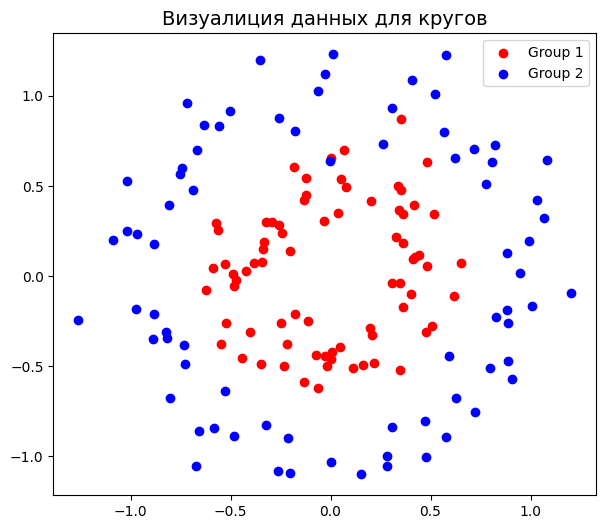

In [235]:
circles_dataset = generate_binary_dataset(n=150, 
                                          dependency_type='circles',
                                          noise=0.1)
_, ax = plt.subplots(figsize=(7,6))
draw_bClassification_dataset(ax, circles_dataset[0], circles_dataset[1], title='Визуалиция данных для кругов')

In [291]:
class KMeans:
    def __init__(self, n_clusters: int, 
                 centroids=None,
                 max_iter=10, tolerance=0.01,
                 distance_metric='euclidean', p=2, 
                 rnd=42):
        self.n_clusters = n_clusters
        self.centroids = centroids
        self.max_iter = 10
        self.tolerance = tolerance
        self.distance_metric = distance_metric
        self.p = p
        self.rnd = rnd

    def distance(self, X1, X2) -> float:
        if self.distance_metric == 'euclidean':
            dist = np.sqrt(np.sum((X1 - X2) ** 2, axis=1))
        if self.distance_metric == 'cityblock':
            dist = np.sum(np.abs(X1 - X2).T,axis=0)
        if self.distance_metric == 'Chebyshev':
            dist = np.max(np.abs(X1 - X2).T,axis=0)  
        if self.distance_metric == 'Minkowski':
            dist = np.power(np.sum(np.power(np.abs(X1 - X2),self.p).T,axis=0),1/self.p)      
        return dist
    
    def init_centroids(self, X):
        if self.rnd: 
            rng = np.random.seed(self.rnd)
            
        c_idxs = np.random.randint(0, X.shape[0], size=self.n_clusters)
        self.centroids = X[c_idxs]
    
    def predict(self, X):
        distances = np.zeros((X.shape[0], self.n_clusters))
        
        for idx, center in enumerate(self.centroids):
            distances[:, idx] = self.distance(X, center)
        self.inertia = np.sum(np.power(np.min(distances, axis=1), 2))
        
        return np.argmin(distances, axis=1)
    
    def transform(self, X):
        return self.predict(X)
    
    def delta_centroids(self,old_centroids):
        return (
                self.distance(self.centroids, old_centroids) 
                / self.distance(old_centroids, np.mean(old_centroids))
               ).mean()
        
    def fit(self, X):
        print(self.centroids)
        if self.centroids is None:
            self.init_centroids(X)
        
        delta = np.inf
        
        for i in range(self.max_iter):
            old_centroids = self.centroids
            
            labels = self.predict(X)
            
            for cluster in range(self.n_clusters):
                idxs = np.where(labels == cluster)
                
                self.centroids[cluster] = X[idxs].mean(axis=0)
            
            if self.delta_centroids(old_centroids) <= self.tolerance:
                break
        
        return self
            
    def fit_transform(self, X):
        return self.fit(X).predict(X)
        
    def visualize(self, X, y, figsize=(8, 6), alpha=0.7, size=50):
        _, ax = plt.subplots(figsize=figsize)
        
        for cluster in range(self.n_clusters):
            idxs = np.where(y == cluster)
            X_iter = X[idxs]
            ax.scatter(x=X_iter[:, 0], y=X_iter[:, 1], label=f'Cluster {cluster}', alpha=alpha, s=size)
            ax.scatter(x=self.centroids[cluster][0], y=self.centroids[cluster][1],
                       s=150, label=f'Center {cluster}', marker='X')
        
        ax.set_title(f'Кластериция {self.n_clusters} групп')
        ax.legend()
        
    def multi_component_visualize(self, 
                                  X,
                                  y, 
                                  combinations,
                                  figsize=(8, 6),
                                  alpha = 0.5,
                                  size = 25,
                                  element_title_legend='Cluster'):   
        fig, ax = plt.subplots(2, 2, figsize = figsize)
        ax = ax.flatten()
        
        for combination, axis in zip(combinations, ax):
            r, x_label, c, y_label = combination
            axis.set_xlabel(x_label or f'Главная компонента {r + 1}')
            axis.set_ylabel(y_label or f'Главная компонента {c + 1}')

            for cluster in range(self.n_clusters):
                idxs = np.where(y == cluster)
                X_iter = X[idxs]
                axis.scatter(x=X_iter[:,r], y=X_iter[:,c], 
                             label=f'{element_title_legend} {cluster}', alpha=alpha, s=size)
                axis.scatter(x=self.centroids[cluster][r], y=self.centroids[cluster][c],
                       s=100, marker='X')
            axis.set_title(f'PCA Кластериция {self.n_clusters} групп')
            axis.legend()
            

def vis_inertia(X):
    sse = []
    list_k = list(range(1, 6))
    for k in list_k:
        km = KMeans(n_clusters=k)
        km.fit(X)
        sse.append(km.inertia)

    plt.figure(figsize=(10, 5))
    plt.plot(list_k, sse, '-o',
            linewidth = 4, markersize = 15)
    plt.xlabel('Число кластеров K', fontsize = 25)
    plt.ylabel('Инерция', fontsize = 25)

    plt.grid();
    plt.xticks(fontsize = 20);
    plt.yticks(fontsize = 20);

None
None
None
None
None
None


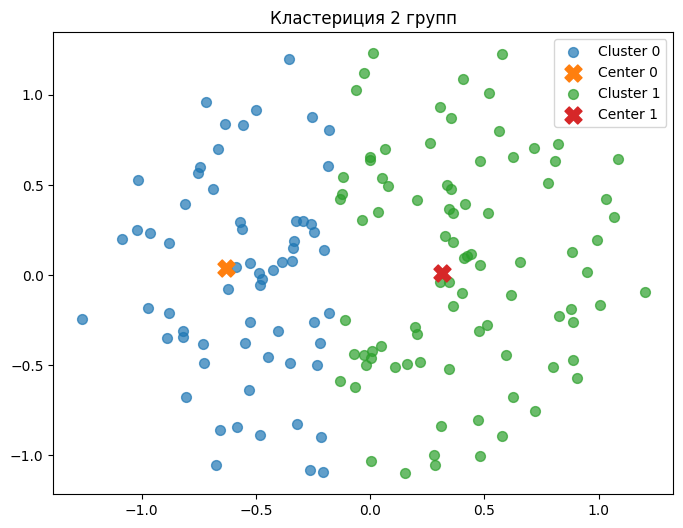

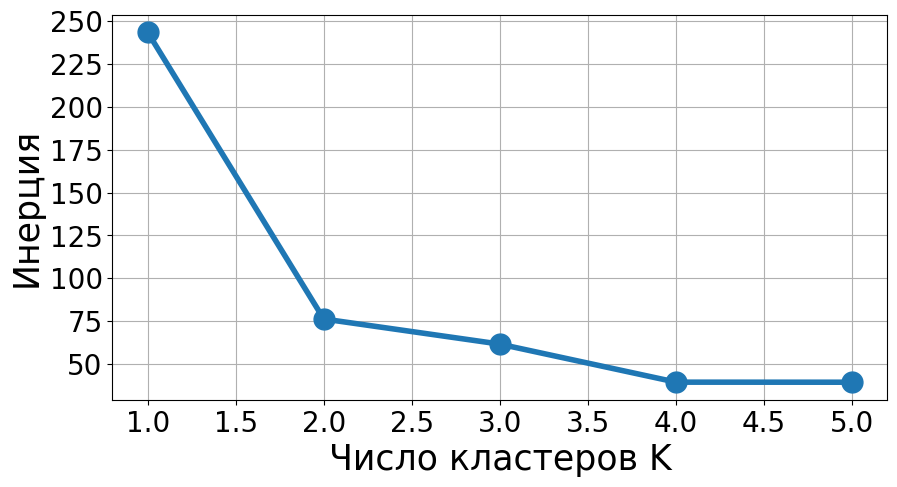

In [252]:
k_means = KMeans(n_clusters=2)
y_hat = k_means.fit_transform(circles_dataset[0])
k_means.visualize(circles_dataset[0], y_hat);
vis_inertia(circles_dataset[0]);

# Алгоритм не может разделить так данные

None
None
None
None
None
None


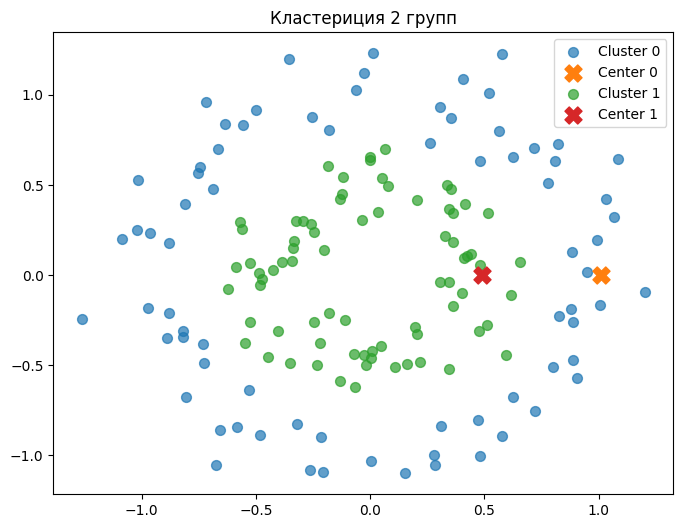

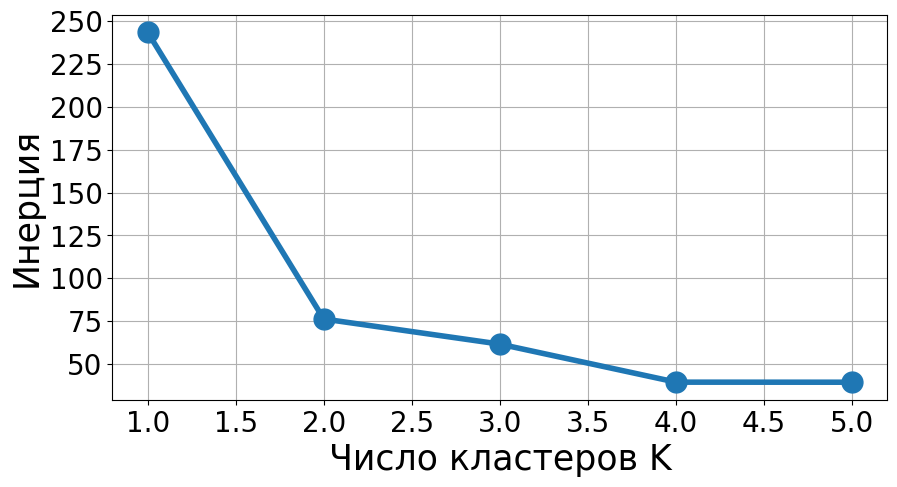

In [253]:
circles_dataset_transformed = circles_dataset[0].copy()
circles_dataset_transformed = np.sqrt(np.sum(circles_dataset_transformed ** 2, axis=1))
circles_dataset_transformed = np.column_stack((circles_dataset_transformed, np.zeros(circles_dataset_transformed.shape)))

k_means = KMeans(n_clusters=2)
predicts = k_means.fit_transform(circles_dataset_transformed)
k_means.visualize(circles_dataset[0], predicts)

# Алгоритм хорошо разделил данные по радиусам, центры стоит воспринимать как расстояние от 0. В обе стороны

vis_inertia(circles_dataset[0])
# 2 кластера лучше всего

# Кластеризация набора данных MNIST

None


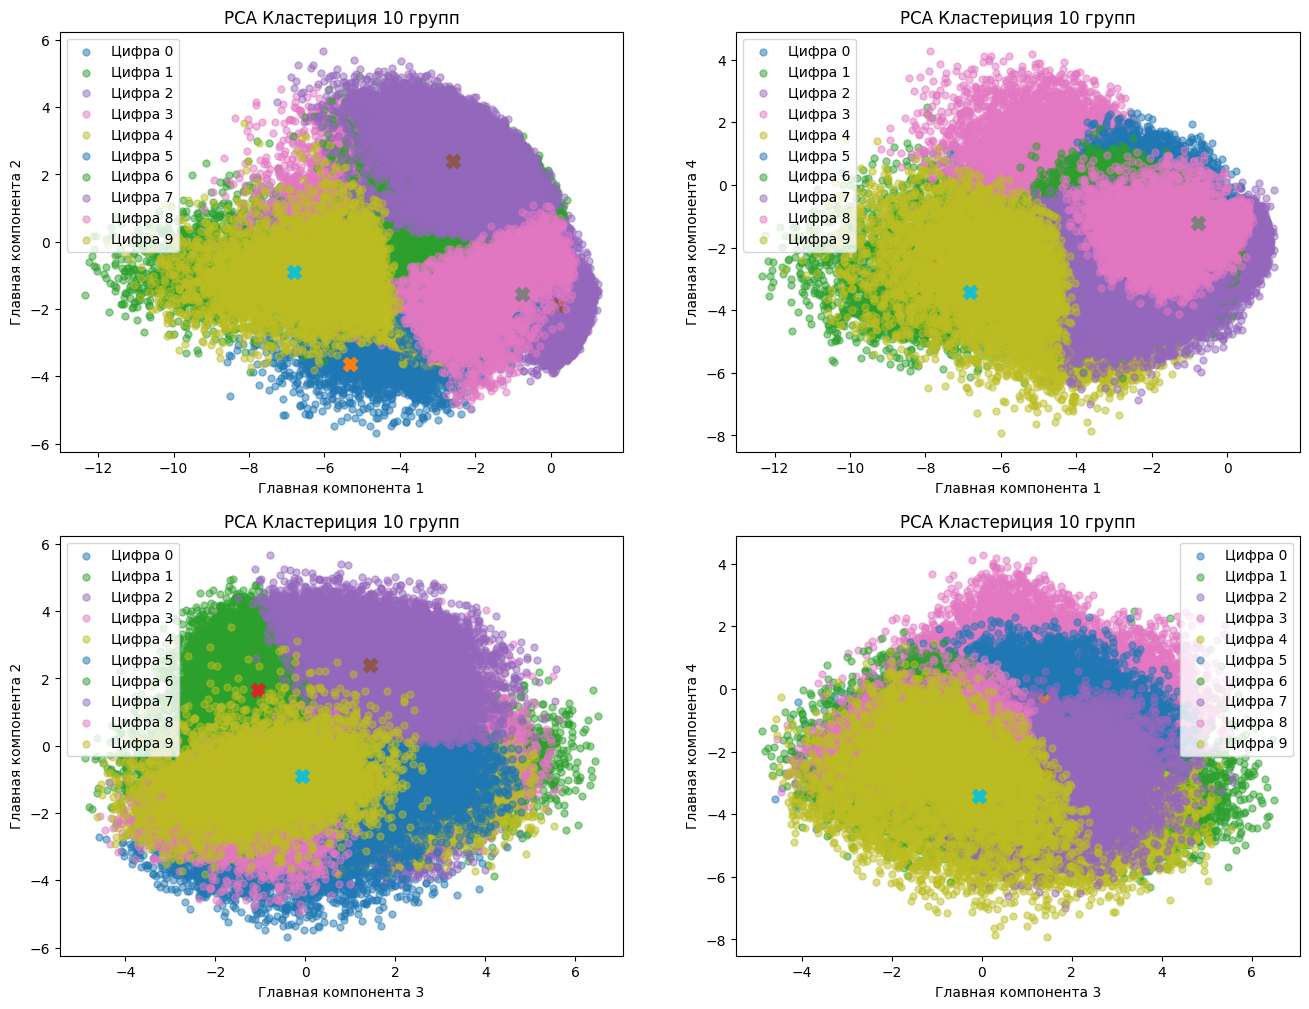

In [293]:
X, y = MNIST_ds
X = X / 255.
X_ = X.values

pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_)

k_means= KMeans(n_clusters=10)
y_hat = k_means.fit_transform(X_pca)

combinations = [
    (0, None, 1, None), (0, None, 3, None), (2, None, 1, None), (2, None, 3, None)
]
k_means.multi_component_visualize(X_pca, y_hat, combinations=combinations, figsize=(16, 12), element_title_legend='Цифра')
# В общем-то есть какое-то раздление, но кластеры пересекаются

In [287]:
pd.crosstab(y, y_hat, rownames=['Метки'], colnames = ['Предсказания'])
# Видно что промахов достаточно много. И нахождение центров по 4 компонента не показывает нам настоящую структуру дата сета MNIST
# По большему счету кластеризация неплохо нашла центр только для числа 7

Предсказания,0,1,2,3,4,5,6,7,8,9
Метки,,,,,,,,,,
0,250,2719,6,675,535,58,54,27,12,2567
1,0,0,6611,1,39,201,34,1,990,0
2,603,355,19,2241,348,2450,99,59,753,63
3,1425,29,128,35,2530,112,702,63,1572,545
4,0,6,150,1190,10,446,2103,2872,47,0
5,447,27,182,67,2150,731,813,572,240,1084
6,35,187,130,3978,329,2120,5,14,46,32
7,0,1,365,60,44,190,2911,3533,176,13
8,161,97,431,97,3220,263,686,431,883,556


# Кластеризация набора данных Cars Moldova

None


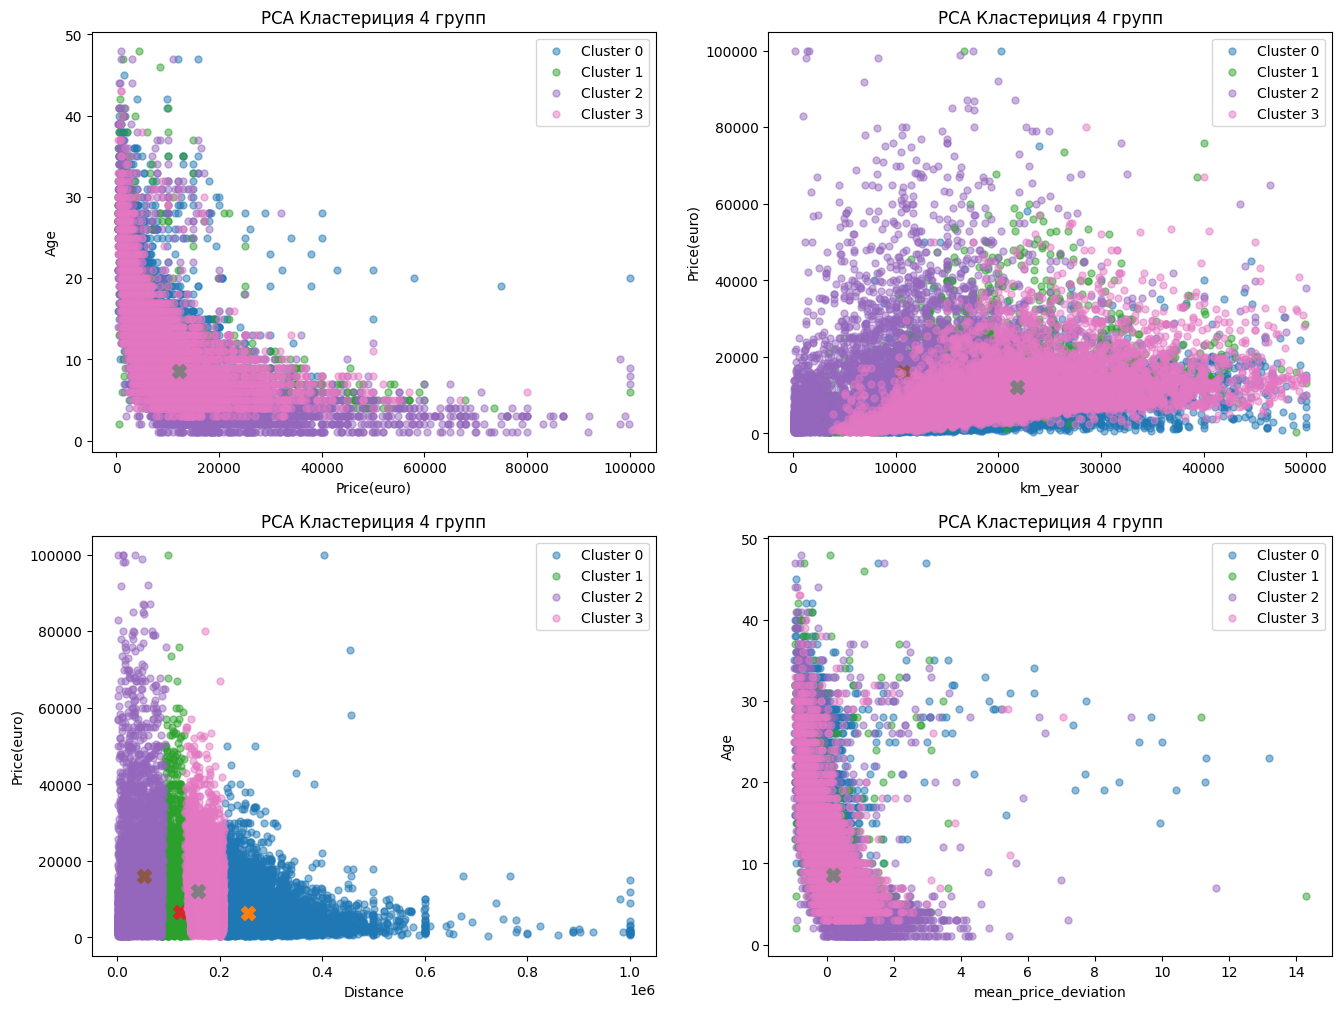

In [298]:
cars_kmeans = KMeans(n_clusters=4) # 4 выбранно произвольно

X_cars = cars_df[num_cols].values
y_hat = cars_kmeans.fit_transform(X_cars)

num_cols # 'Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)', 'Age', 'km_year', 'mean_price_deviation'
# Отберем наиболее интересные для визуализации признаки

combinations = [
    [3, num_cols[3], 4, num_cols[4]], # Цена к возрасту
    [5, num_cols[5], 3, num_cols[3]], # Километраж в год к цене
    [1, num_cols[1], 3, num_cols[3]], # Километраж к цене
    [6, num_cols[6], 4, num_cols[4]] # отклонение от цены к возрасту
]
cars_kmeans.multi_component_visualize(X_cars, y_hat, combinations=combinations, figsize=(16, 12))

# Получилось интересная кластеризация в разрезе Distance - Price
# Что-то среднее вышло в разре km_year - Price
# Есть какой-то тренд у Price - Age и mean_price_deviation -> Age

In [345]:
# Посмотрим как кластеризацию увидит разбиенеи по какому-то категориальному признаку
style_clusters = cars_df.nunique()['Style'] # Посмотрим на признак Style

style_k_means = KMeans(n_clusters=style_clusters)
y_hat = style_k_means.fit_transform(X_cars)

styles_label_encoder = LabelEncoder()
styles_label_encoder.fit(cars_df['Style'])

y_hat_styles = styles_label_encoder.inverse_transform(y_hat)
pd.crosstab(cars_df['Style'], y_hat_styles, rownames=['Метка'], colnames = ['Предсказания'])

# Неплохо разбирили Седаны и кроссоверы, в остальном конечно все плачевно)
# Но зато показательно, что все таки класстеризация хороший метод для проверки гипотез

None


Предсказания,Cabriolet,Combi,Coupe,Crossover,Hatchback,Microvan,Minivan,Pickup,Roadster,SUV,Sedan,Universal
Метка,,,,,,,,,,,,
Cabriolet,10,6,4,0,12,7,10,0,13,1,10,0
Combi,56,23,8,1,31,27,24,14,30,21,56,5
Coupe,81,24,27,7,54,37,25,2,26,44,47,4
Crossover,334,192,412,203,638,329,277,350,288,52,354,219
Hatchback,778,470,213,14,474,529,437,121,569,177,726,30
Microvan,69,14,4,4,35,53,16,14,38,45,64,6
Minivan,529,127,57,24,170,293,147,81,222,230,367,21
Pickup,8,2,10,3,17,6,6,1,1,1,2,2
Roadster,2,2,0,0,4,2,2,0,0,1,1,1
